In [ ]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the final layer for binary classification (2 classes: live, dead)
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=2)

model.load_state_dict(state_dict=torch.load(r"C:\rkka_Projects\cell_death_v1\finetuning\2d_qpi\qpi_model_epoch_2_val_acc_100.00.pth"))

C:\Users\김민욱\AppData\Local\Temp\ipykernel_19588\1582547790.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(state_dict=torch.load(r"C:\rkka_Project

<All keys matched successfully>

In [ ]:
from torch_tomogram_dataset import TomogramDataset2DQPI
from torch.utils.data import DataLoader
from torch_tomogram_dataset.utils import calculate_dataset_mean_std
from torchvision import transforms

path = r"C:\rkka_Projects\cell_death_v1\Data\train"

# Initialize
train_dataset = TomogramDataset2DQPI(root_dir=path, rescale=True, transform=None, augmentation=False)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)
mean, std = calculate_dataset_mean_std(loader=train_loader)

# Normalize & Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean, std)
])
train_dataset = TomogramDataset2DQPI(root_dir=path, rescale=True, transform=transform, augmentation=False)
train_loader = DataLoader(dataset=train_dataset, shuffle=True)

In [ ]:
import cv2
import numpy as np

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        # If no class index is provided, use the predicted class
        if class_idx is None:
            class_idx = output.argmax().item()

        # Zero grads, backward pass, and compute gradients
        self.model.zero_grad()
        output[:, class_idx].backward()

        # Compute Grad-CAM
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))  # global average pooling

        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU activation
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.shape[3], input_tensor.shape[2]))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [ ]:
from torchvision import transforms

# Load the model and set it to evaluation mode
model = models.resnet50(pretrained=True)  # Use your trained model here
model.eval()

# Initialize Grad-CAM with the target layer
grad_cam = GradCAM(model, model.layer4[-1])

# Preprocess the input image
images, labels = next(iter(train_loader))
input_tensor = images[0]
input_tensor = (input_tensor - input_tensor.min())/(input_tensor.max() - input_tensor.min())
input_tensor = transform(input_tensor)

# Generate the heatmap
heatmap = grad_cam.generate_heatmap(input_tensor)

In [3]:
import napari
viewer = napari.Viewer()

RuntimeError: wrapped C/C++ object of type QMenuItemAction has been deleted

In [2]:
from torch_tomogram_dataset import TomogramDataset2DQPI, TomogramDataset2DMIP, TomogramDataset3D
from torch.utils.data import DataLoader

train_root = r"C:\rkka_Projects\cell_death_v1\Data\temp"
train_dataset = TomogramDataset3D(root_dir=train_root, rescale=False, transform=None, augmentation=False)
train_loader = DataLoader(dataset=train_dataset, batch_size=8)

In [3]:
images, labels = next(iter(train_loader))
sample = images[0]

In [6]:
viewer.add_image(sample)

<Image layer 'sample' at 0x28ca78ee630>

INFO: Plugin Manager: All available plugins loaded



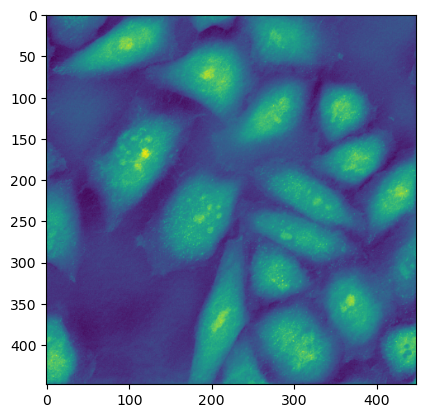

In [39]:
import matplotlib.pyplot as plt
plt.imshow(sample[0])